In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from music21 import midi
from music21 import note, stream, duration
from music21 import converter

from models.MuseGAN import MuseGAN
from utils.loaders import load_music
from keras.models import load_model

2021-11-11 08:16:30.760807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 08:16:30.760874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Se declaran las variables que serán usadas a lo largo del programa.

In [2]:
SECTION = 'compose'
RUN_ID = '0017'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
directory = os.getcwd()
RUN_FOLDER = os.path.join(directory,"run",SECTION,'_'.join([RUN_ID, DATA_NAME]))

In [4]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
# data_binary = np.squeeze(data_binary)

In [5]:
#Se definen los parámetros de la GAN, está debe coincidir con el modelo entranado en el jupyter previo.
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
)

Instructions for updating:
Colocations handled automatically by placer.


2021-11-11 08:16:49.716304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-11 08:16:49.716361: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-11 08:16:49.716416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (78cfd8a7660e): /proc/driver/nvidia/version does not exist
/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [6]:
#El método load_weights nos permite recuperar el valor de los parámetros que se obtuvieron al entrenar el modelo. 
gan.load_weights(os.path.join(RUN_FOLDER))

2021-11-11 08:17:05.545492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 08:17:06.368172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1996190000 Hz


In [7]:
#Se muestra un resumen con las capas utilizadas para la construcción de la arquitectura del generador.
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
___________________________________________________________________________________________

In [8]:
#De manera análoga se muestra un resumen de las capas para el crítico (discriminante/clasificador).
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_2 (Conv3D)            multiple                  196736    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

In [9]:
#Generamos diferentes vectores de contexto para visualizar los cambios que el generador realizará en la composición de las diferentes melodías.
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

Vamos a crear nuestra primer canción que se almacena mediante su representación númerica en la variable **gen_scores**

En este caso como mencionamos anteriormente, las entradas serán los acordes, el estilo, la melodía y los tonos. Todas las entradas con un ruido asignado.


In [10]:
gen_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise])

/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [11]:
np.argmax(gen_scores[0,0,0:4,:,3], axis = 1)

array([54, 55, 50, 54])

In [12]:
gen_scores[0,0,0:4,60,3] = 0.02347812

Ahora generamos una visualización de la información que obtuvimos, en este caso necesitamos hacer el parseo a el tipo de archivo **midi** que hemos venido utilizando .

La imagen que vemos a continuación es el resultado que obtuvimos y en la carpeta de samples vamos a tener acceso a todos las predicciones que hagamos

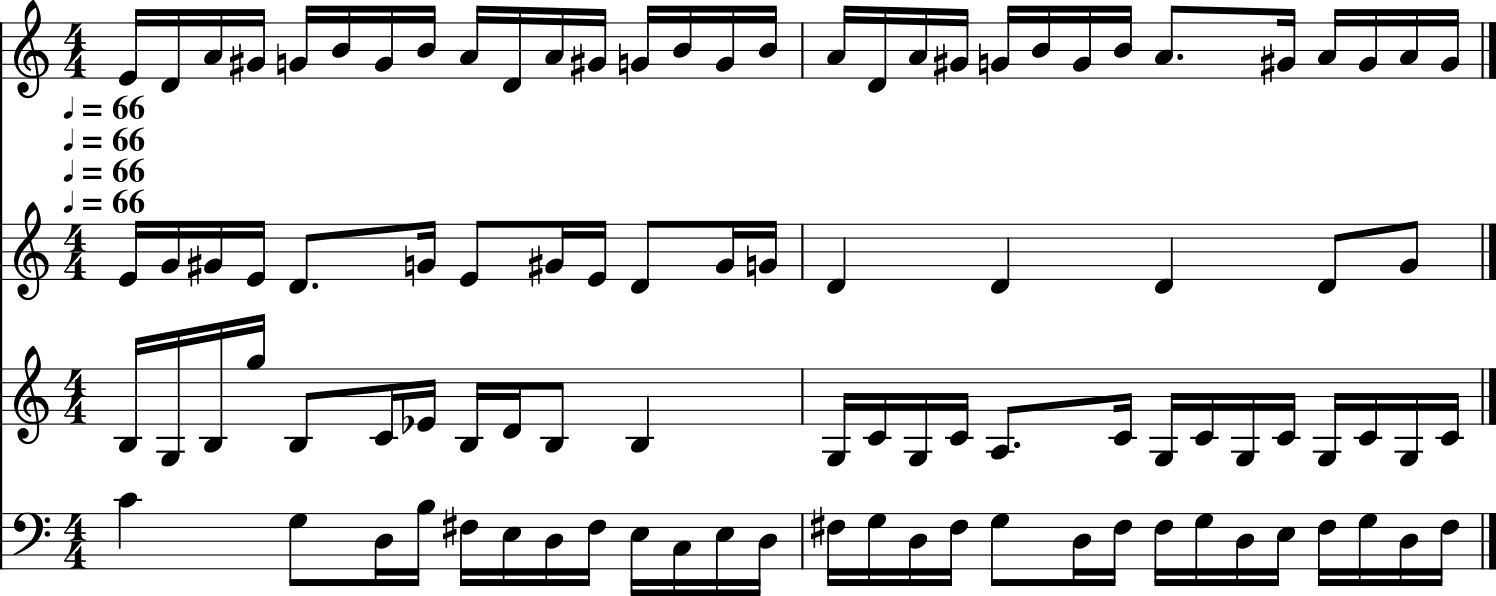

In [13]:
filename = 'example'
gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
gen_score.show()

Está gráfica es una representación  de los 2 compases por las 4 pistas que creamos con  anterioridad.

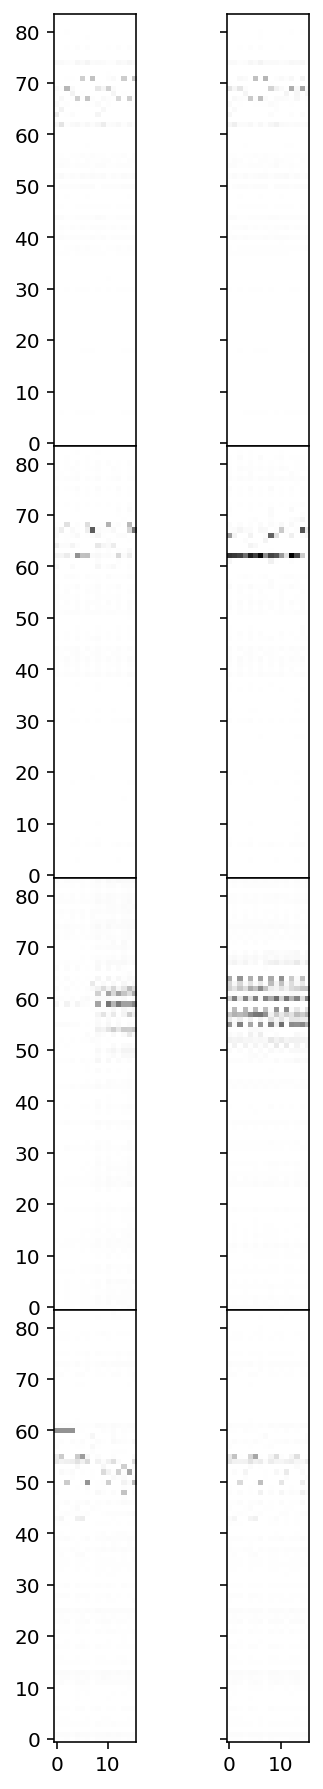

In [14]:
gan.draw_score(gen_scores, 0)

In [15]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i

In [16]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

123


En esta sección se muestran dos diferentes gráficas, una con la pista original vs diferentes pistas obtenidas al producir en mayor medida ruido sobre cada una de las diferentes entradas que el generador de MuseGAN recibe.


original


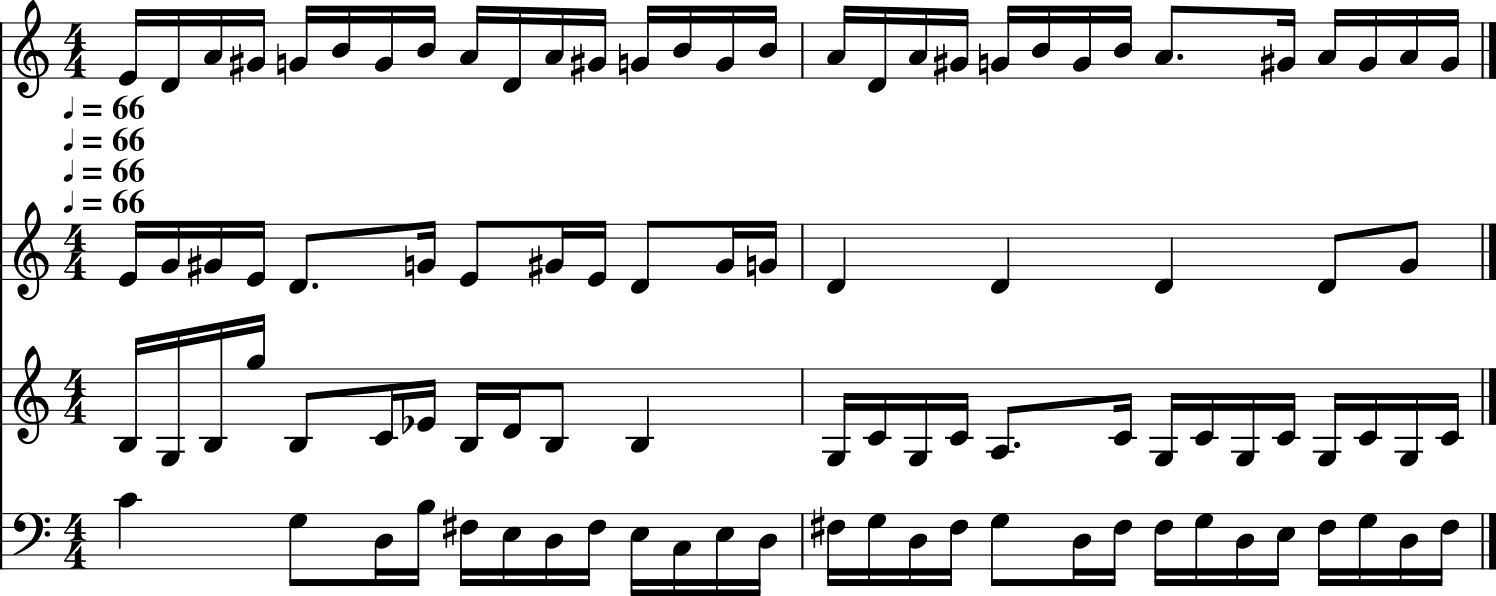

closest


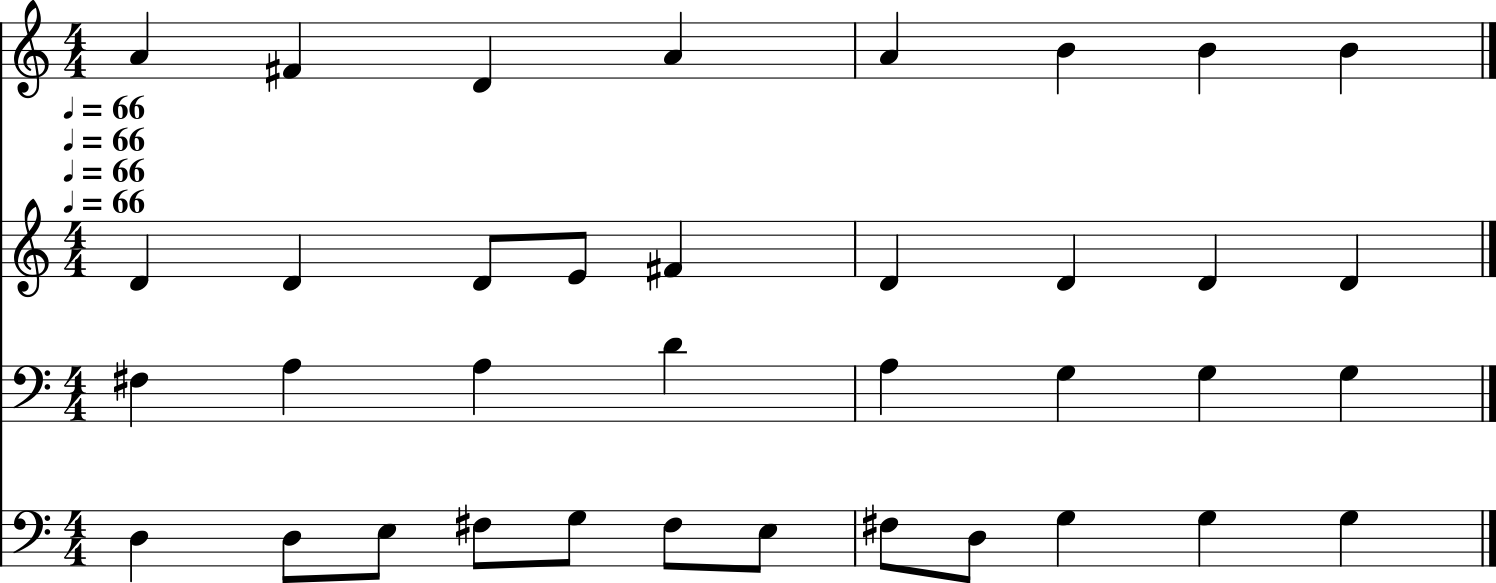

In [17]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = converter.parse(os.path.join(RUN_FOLDER, 'samples','{}.midi'.format(filename)))
print('original')
gen_score.show()
print('closest')
closest_score.show()

In [18]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))

In [19]:
chords_scores = gan.generator.predict([chords_noise_2, style_noise, melody_noise, groove_noise])

Al modificar en mayor medida a los acordes con un ruido mayor.

original


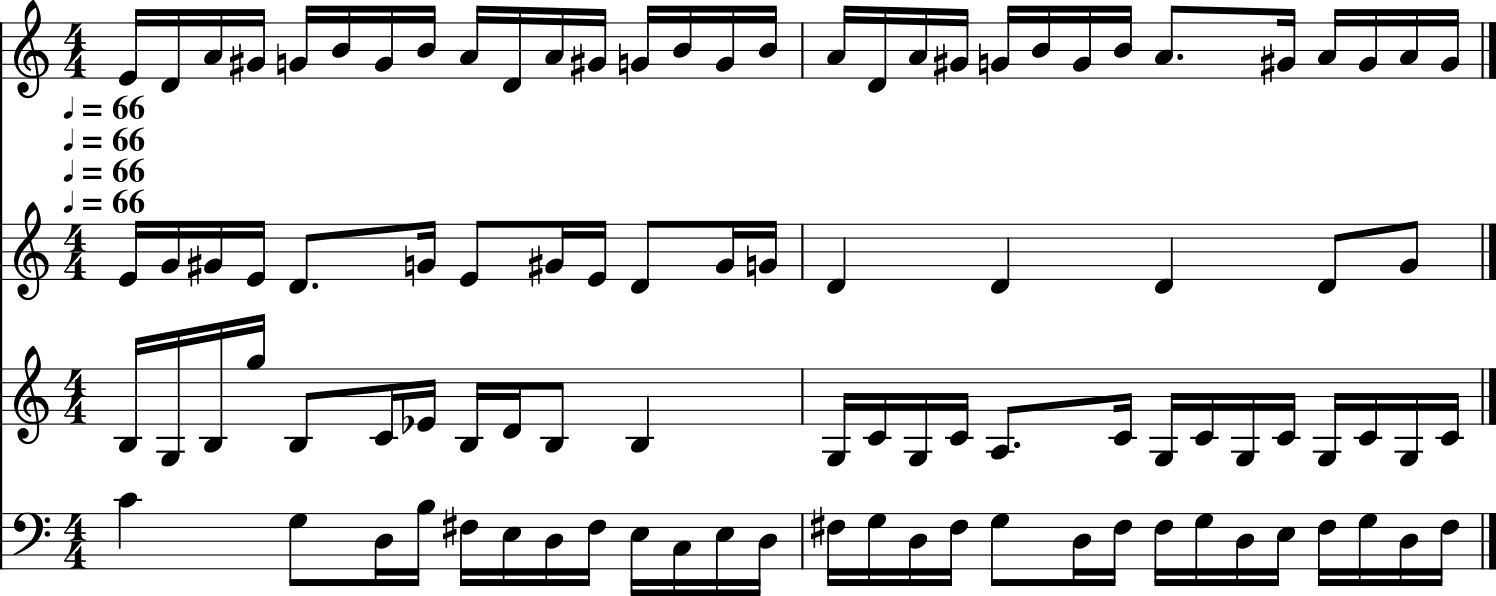

chords noise changed


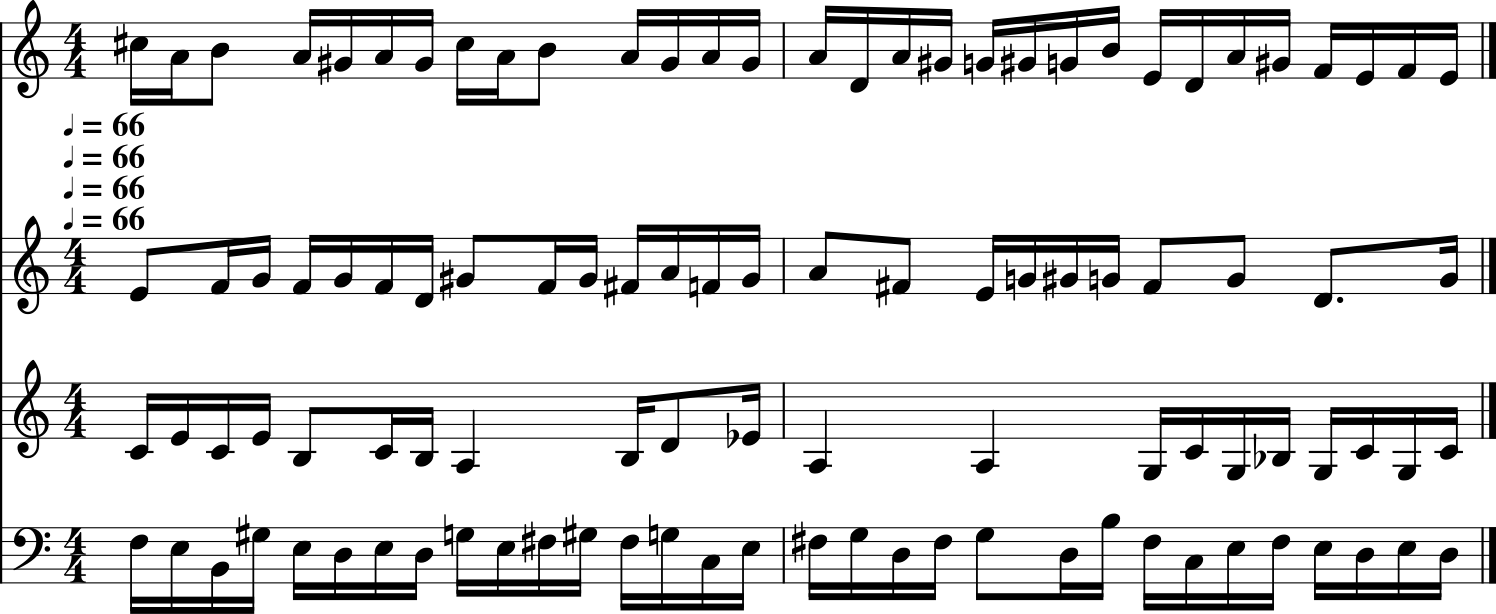

In [20]:
filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('chords noise changed')
chords_score.show()

In [21]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))

In [22]:
style_scores = gan.generator.predict([chords_noise, style_noise_2, melody_noise, groove_noise])

Los cambios realizados en la característica __style__ da cómo un resultado mucho más diferente al original, puesto qué, a lo largo de la creación de una pista esta es una propiedad cambia constantemente

original


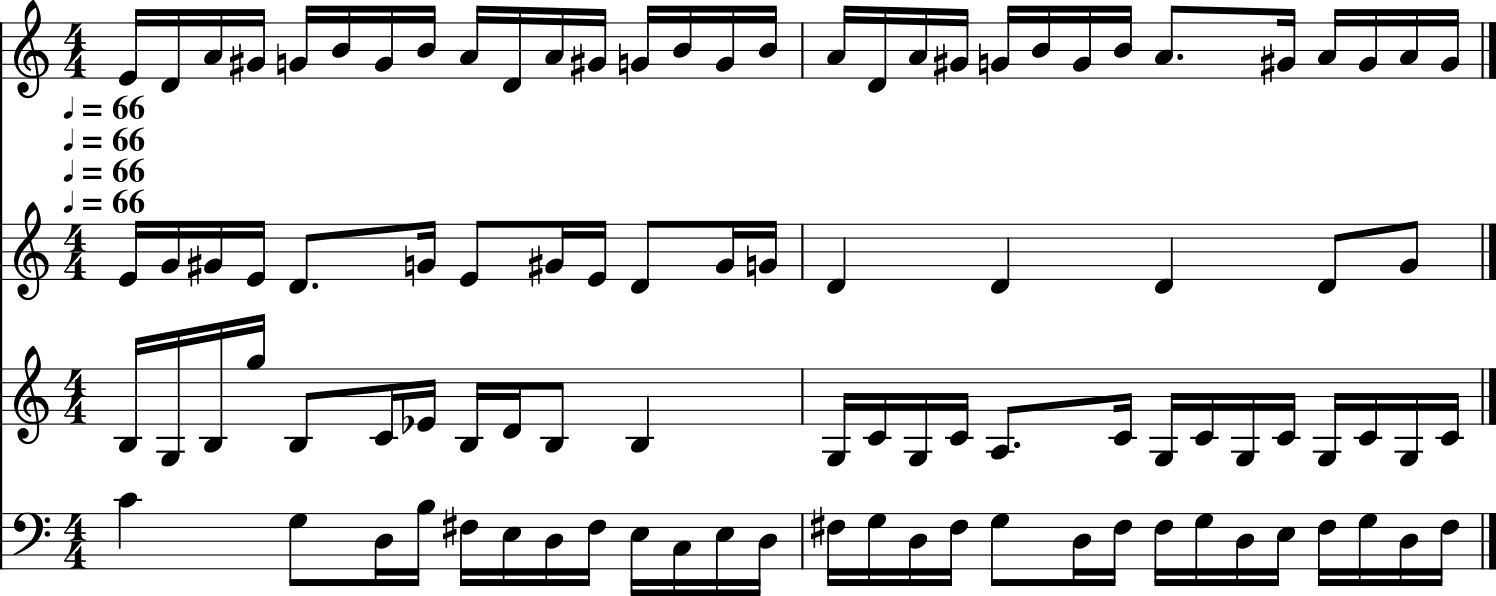

style noise changed


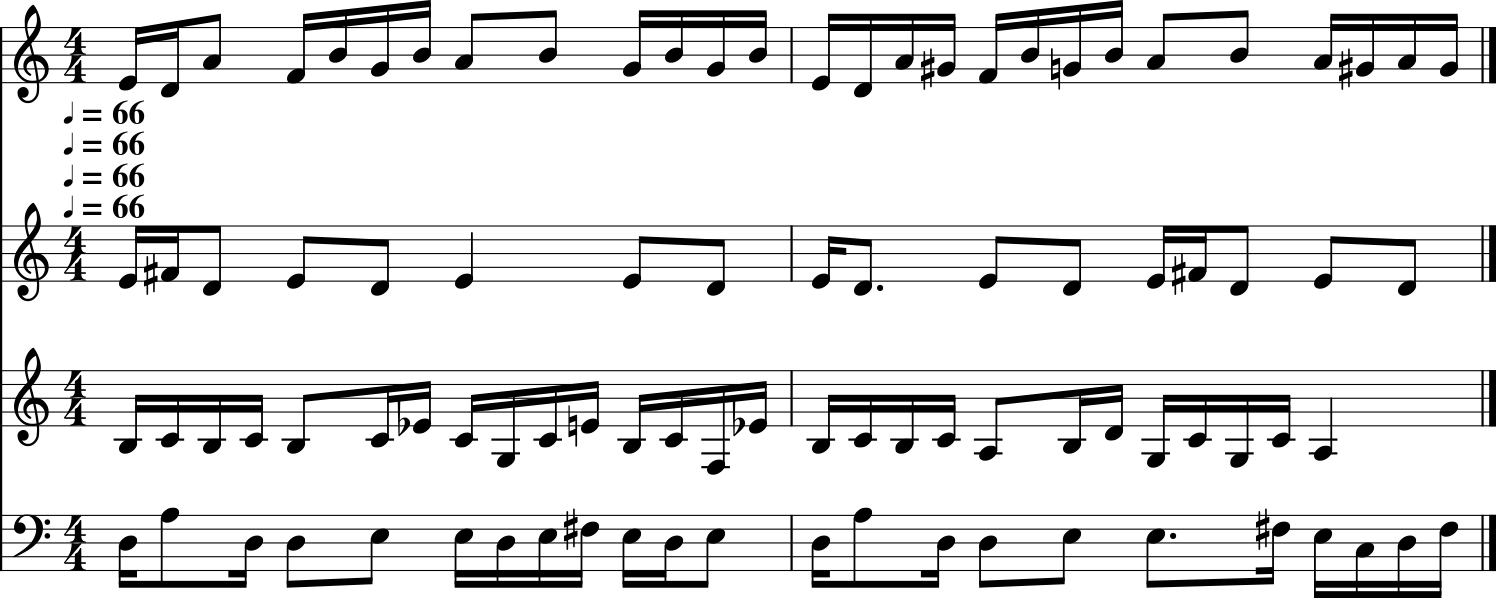

In [23]:
filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('style noise changed')
style_score.show()

In [24]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim)

In [25]:
melody_scores = gan.generator.predict([chords_noise, style_noise, melody_noise_2, groove_noise])

Para la entrada de la melodía podemos observar que dadas sus condiciones constantes a lo largo de la pista los cambios que sufre son menores que con otra característica, se pueden ver reflejados en compases especificos o en tracks enteros pero no en toda la pista generada.

original


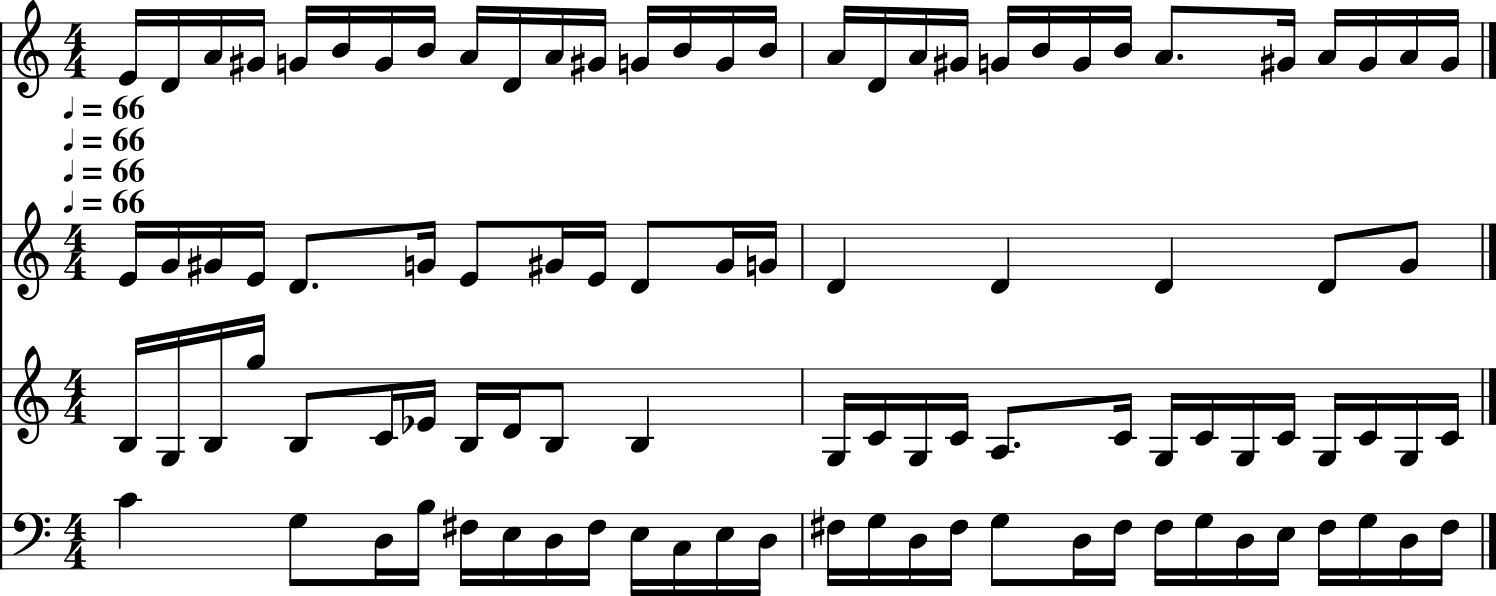

melody noise changed


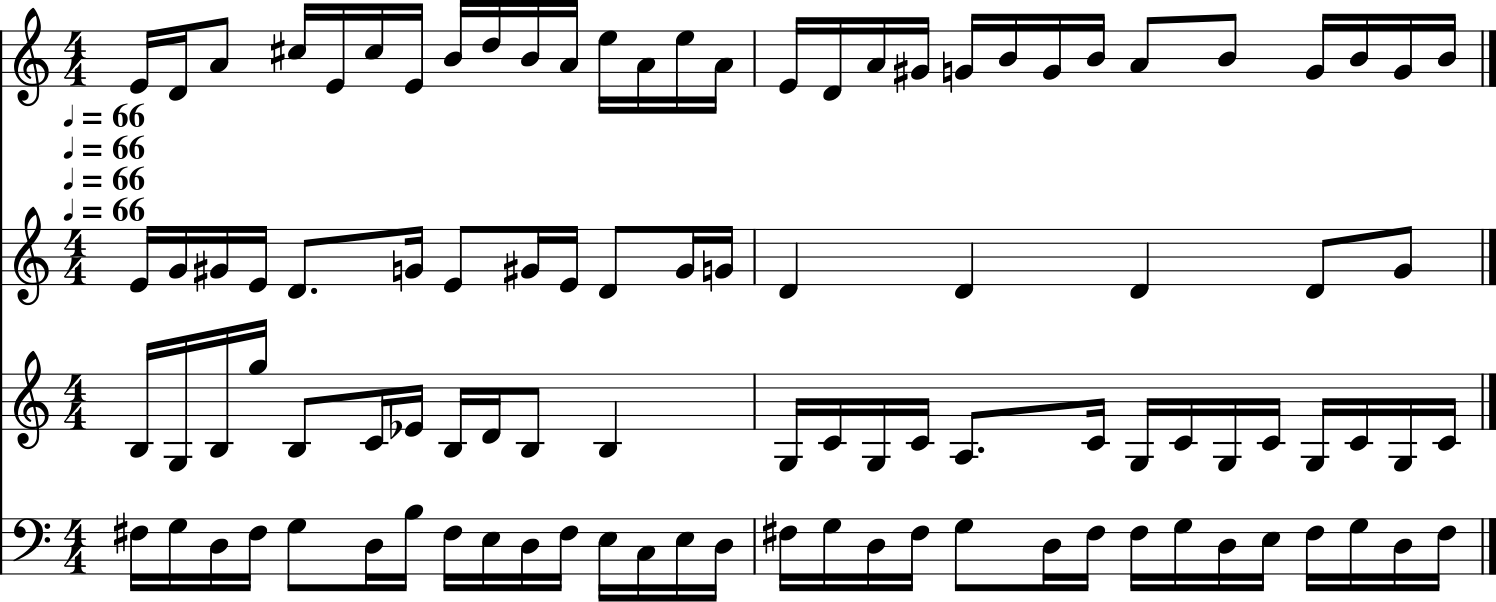

In [26]:
filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('melody noise changed')
melody_score.show()

In [27]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)

In [28]:
groove_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise_2])

A diferencia de las entradas anteriores, dado que el tono es un elemento que no sufre muchas transformaciones en la generación de la pista, podemos observar que si aumentamos el ruido de dicha entrada las diferencias entre la entrada original y la modificada son pocas.

original


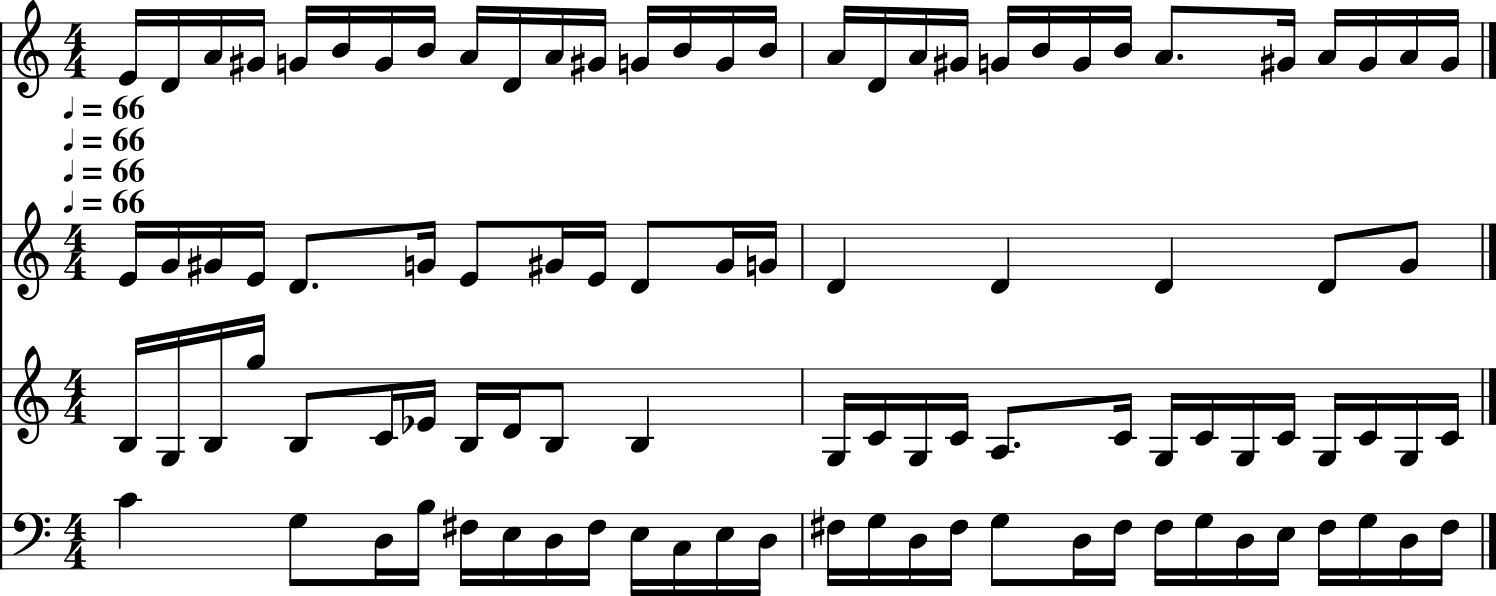

groove noise changed


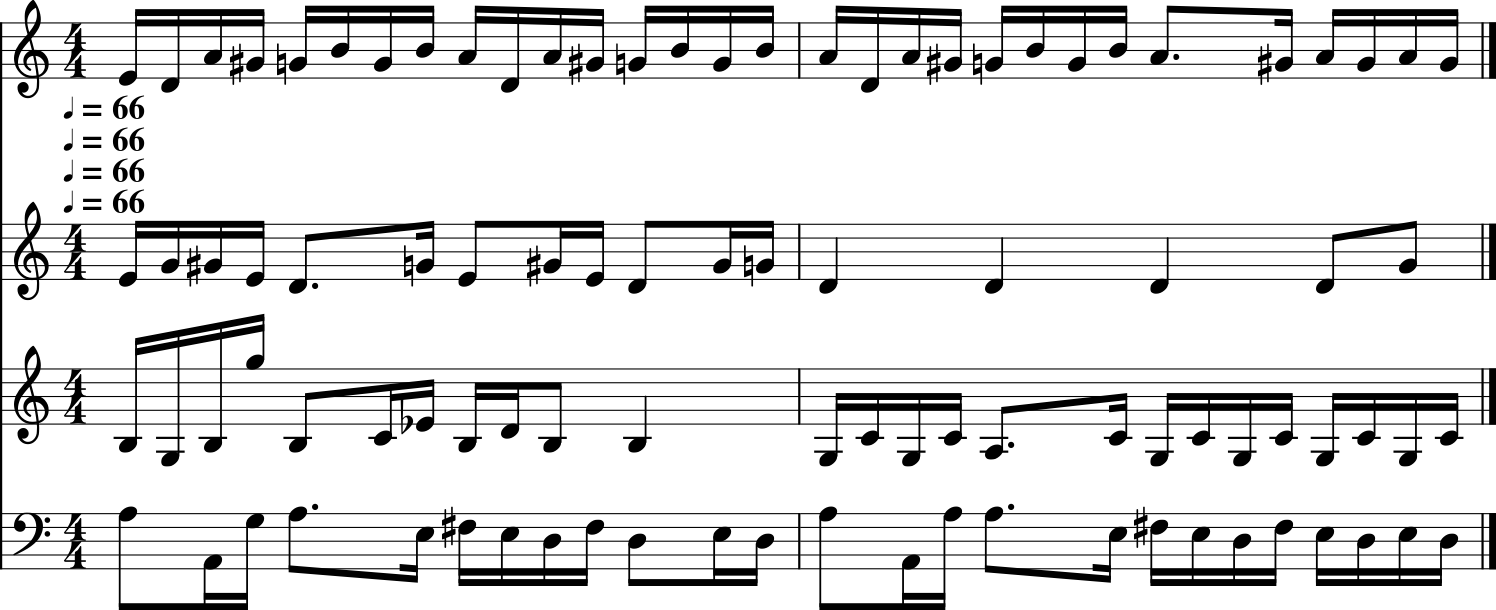

In [29]:
filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('groove noise changed')
groove_score.show()

In [30]:
from music21 import corpus, converter
from IPython.display import Image, Audio
def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(str(filename) + '.wav'))

In [34]:
#Canción generada
original_score = converter.parse("run/compose/0017_chorales/samples/changing_melody.midi").chordify()
play(original_score)

Parameter 'font.sf2' not a SoundFont or MIDI file or error occurred identifying it.
